In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
#%matplotlib notebook

import matplotlib.pyplot as plt 
import datetime as dt
import matplotlib.dates as mdates
from scipy import stats as st

# Продуктовый анализ мобильного приложения
# стартап, который продаёт продукты питания

Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

Посмотрим результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, и нам надо понять как пользователи отреагируют на данные изменения.

1. [Подготовка данных](#step0) 
2. [Изучение и проверка](#step1)
3. [Метрики](#step6)
4. [Воронка событий](#step2)
5. [Результаты эксперимента](#step3)
6. [Выводы](#step4)

## Подготовка данных <a id="step0"></a>

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

data =  pd.read_csv('/datasets/logs_exp.csv', sep='\t')

# изменим название столбцов
data.columns = map(str.lower, data.columns)
data = data.rename({'deviceidhash': 'id', 'expid': 'exper'}, axis='columns')

# поработаем с датой
data['date_time'] = pd.to_datetime(data['eventtimestamp'], unit='s')
data['date'] = data['date_time'].dt.date


In [3]:
# функция сравнения
def stat (df, column1, column2, alpha):
   
    events = df.index 
    for i in range(1, 5):
        alpha = alpha
        row1 = np.array([df.loc[events[0], column1], df.loc[events[0], column2]]) # выбираем количество пользователей в группе
        row2 = np.array([df.loc[events[i], column1], df.loc[events[i], column2]])
       # print(row1, row2)
        p1 = row2[0] / row1[0]
        p2 = row2[1] / row1[1]
       # print(p1, p2)
        p_combined = (row2[0] + row2[1]) / (row1[0] + row1[1])
        difference = p1 - p2
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/row1[0] + 1/row1[1]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница",events[i])
        else:
            print("Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень -",events[i])


Поменяем названия событий

In [4]:
# 
slovar = {'CartScreenAppear': '3_CART', 'MainScreenAppear': '1_ENTER','OffersScreenAppear': '2_OFFERS', 'PaymentScreenSuccessful': '4_PAYMENT','Tutorial':'HELP'}

data['event'] = data['eventname'].map(slovar)

data.head(3)

,eventname,id,eventtimestamp,exper,date_time,date,event
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,1_ENTER
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,1_ENTER
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,4_PAYMENT


In [5]:
#посмотрим дубликаты и пропуски
data.describe(include = 'all')
print('Дубликаты составляют - ', data.duplicated().sum())

# удалим дубликаты
data = data.drop_duplicates().reset_index(drop= True)
data

Дубликаты составляют -  413


,eventname,id,eventtimestamp,exper,date_time,date,event
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,1_ENTER
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,1_ENTER
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,4_PAYMENT
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,3_CART
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,4_PAYMENT
...,...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07,1_ENTER
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07,1_ENTER
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07,1_ENTER
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07,1_ENTER


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 7 columns):
eventname         243713 non-null object
id                243713 non-null int64
eventtimestamp    243713 non-null int64
exper             243713 non-null int64
date_time         243713 non-null datetime64[ns]
date              243713 non-null object
event             243713 non-null object
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.0+ MB


Мы подготовили данные - удалили дубликаты, поменяли названия столбцов и  выделили столбцы с временем и отдельно с датами логов.

## Изучение и проверка <a id="step1"></a>


1. [Сколько в среднем событий приходится на пользователя](#step11)  
2. [Количество платежей на одного пользователя](#step15)
3. [Удаление данных](#step16) 
4. [Выводы](#step14) 

Посмотрим сколько всего событий  и пользователей в логе, как они распределены на пользователей и нет ли аномалий в этих распределениях.

In [7]:
print('Количество событий в наших данных - ', len(data))
print('Количество уникальных пользователей-',data['id'].nunique())
print('Начальная дата эксперимента -',data['date_time'].min(), 'Конечная дата эксперимента -',data['date_time'].max())

Количество событий в наших данных -  243713
Количество уникальных пользователей- 7551
Начальная дата эксперимента - 2019-07-25 04:43:36 Конечная дата эксперимента - 2019-08-07 21:15:17


### Сколько в среднем событий приходится на пользователя <a id="step11"></a>

Посмотрим одновременно гистограмму и график плотности распределения событий на одного пользователя

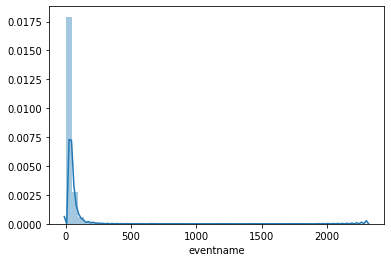

In [8]:
tab = data.groupby(['id'])['eventname'].count()
sns.distplot(tab);

Все они сосредоточены у 0 но есть большой хвост когда на одного пользователя приходится более 2000 логов. Возможно это тестировщики и следует от этих пользователей избавиться, так как они будут искажать нашу воронку и результаты тестирования.

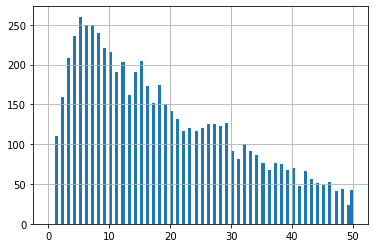

In [9]:
tab.sort_values().hist(range = (0,50), bins = 100)

In [10]:
print('Перцентиль 95 и 99 по количеству логов на пользователя - ', np.percentile(tab, [95, 99]))

Перцентиль 95 и 99 по количеству логов на пользователя -  [ 89.  200.5]


Посмотрим медианное количество логов для каждого эксперимента:

In [11]:
print('Количество событий на одного пользователя- ',data.groupby(['id'], as_index = False)['eventname'].count()['eventname'].median())

Количество событий на одного пользователя-  20.0


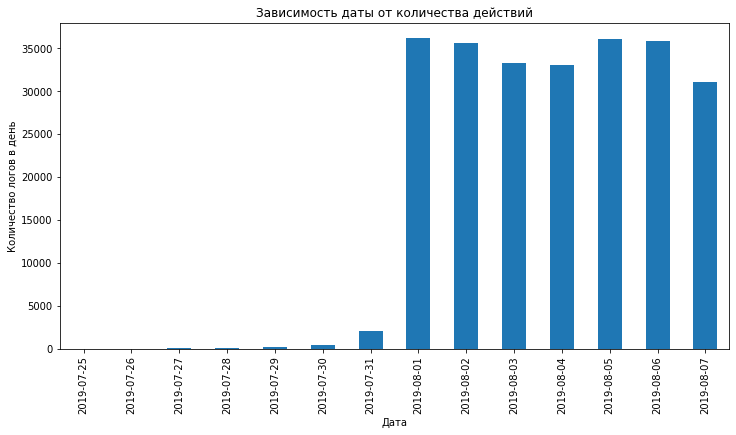

In [12]:

fig, ax = plt.subplots()
data.groupby('date')['id'].count().plot(kind = 'bar', figsize=(12, 9))

#ax.legend()
plt.xlabel('Дата')
plt.ylabel('Количество логов в день')
plt.title('Зависимость даты от количества действий')
fig.set_figheight(6)
fig.set_figwidth(12)
plt.show() 


Отбросим данные ранее - 01-08, судя по гистограмме - среднее количество логов в день у данного приложения - 35000 а раньше явная нехватка. 
Так же уберем пользователей из выборки у которых суммарное количество логов больше 200 за время в наших данных. 

Получится, у нас будут данные за полную неделю


#### Посмотрим как сейчас у нас распределены данные по тестам и логам

In [13]:
old_table = data.pivot_table(index = 'event', columns = 'exper', values = 'id', aggfunc = 'count')
old_table

exper,246,247,248
event,,,
1_ENTER,38249,39677,41175
2_OFFERS,14904,15341,16563
3_CART,14798,12548,15322
4_PAYMENT,11912,10039,12167
HELP,318,345,355


Посмотрим сколько данных у нас останеться и правильно ли будут распределены пользователи в трех выборках после удаления части данных

In [14]:
users = data.groupby(['id'], as_index = False)['event'].count().\
        loc[lambda x: x['event'] < 200]['id']
big_users = data.groupby(['id'], as_index = False)['event'].count().\
        loc[lambda x: x['event'] >= 200]['id']


new_table = data.query('"2019-08-01" <= date_time < "2019-08-08" and id in @users')

new_table.pivot_table(index = 'id', columns = 'event', values = 'date', aggfunc = 'count')

event,1_ENTER,2_OFFERS,3_CART,4_PAYMENT,HELP
id,,,,,
6888746892508752,1.0,NaN,NaN,NaN,NaN
6909561520679493,2.0,1.0,1.0,1.0,NaN
6922444491712477,19.0,12.0,8.0,8.0,NaN
7435777799948366,6.0,NaN,NaN,NaN,NaN
7702139951469979,40.0,87.0,5.0,5.0,NaN
...,...,...,...,...,...
9217594193087726423,NaN,3.0,3.0,3.0,NaN
9219463515465815368,11.0,4.0,1.0,1.0,NaN
9220879493065341500,4.0,1.0,1.0,NaN,NaN


Мы видим что путь пользователя совершенно не всегда прямолиненен и равномерен, некоторые долго топчутся на первых экранах, а кто-то пропускает главный и попадает сразу в окно оплаты.

### Количество платежей на одного пользователя <a id="step15"></a>

Перцентиль 95 и 99 по количеству платежей на пользователя -  [19.   39.38]


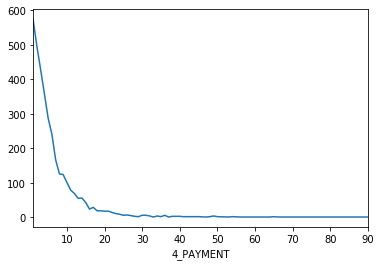

In [15]:
table =new_table.pivot_table(index = 'id', columns = 'event', values = 'date', aggfunc = 'count').fillna(0).\
            sort_values(by = 'HELP').astype(int)
tab = table[table['4_PAYMENT'] > 0].sort_values(by = '4_PAYMENT')#['4_PAYMENT']#.groupby(['4_PAYMENT'])['4_PAYMENT']#.count()
print('Перцентиль 95 и 99 по количеству платежей на пользователя - ', np.percentile(tab['4_PAYMENT'], [95, 99]))
tab.groupby(['4_PAYMENT'])['4_PAYMENT'].count().plot()

Даже после чистки базы по количесту событий на пользователя, прийдется еще раз удалять данные по количесту платежей на пользователя - больше 40.

### Удаление данных <a id="step16"></a>

In [16]:
tab= tab.reset_index()
big_byer = tab.loc[lambda x: x['4_PAYMENT'] >= 40]['id']
users_byer = tab.loc[lambda x: x['4_PAYMENT'] < 40]['id']
big_byer_table = new_table.query('id in @big_byer').index

new_table = new_table[~new_table.index.isin(big_byer_table)]

In [17]:
print('Количество пользователей удаленных из выборки - {}'.format(data['id'].nunique() - new_table['id'].nunique()))
print('В процентах от общего числа - {:.2%}'.format((data['id'].nunique() - new_table['id'].nunique()) / data['id'].nunique()))

Количество пользователей удаленных из выборки - 128
В процентах от общего числа - 1.70%


In [18]:
print('Количество событий удаленных из выборки - {}'.format(data['date_time'].count() - new_table['date_time'].count()))
print('В процентах от общего числа - {:.2%}'.format((data['date_time'].count() - new_table['date_time'].count()) /data['date_time'].count()))

Количество событий удаленных из выборки - 42501
В процентах от общего числа - 17.44%


### Выводы <a id="step14"></a>

Мы удалили 128 пользователи которые занимали всего 1,7 процент от общего числа пользователей в нашей выборке, но при этом получилось что количество событий, которые были созданы этими пользователями и сейчас удалены  являются - 17% от общего числа всех событий которые были в наших выборках.

## Метрики <a id="step6"></a>


1. [Retention Rate](#step12) 
5. [Paying Conversion](#step13) 

### Как часто пользователь заходит в приложение <a id="step12"></a>

Рассчитаем Retention Rate

Добавим данные первого входа и первой покупки. Создадим столбцы с первым входом и первой покупкой

In [19]:
min_visit = new_table.groupby(['id']).agg(first_datetime = ('date_time','min'))
min_visit['first_date'] = min_visit['first_datetime'].dt.date
new_table = new_table.merge(min_visit, on = 'id')

min_byer = new_table.query('event == "4_PAYMENT"').groupby(['id']).agg(first_byertime = ('date_time','min'))
min_byer['first_byer'] = min_byer['first_byertime'].dt.date
new_table = new_table.merge(min_byer, how='outer', on = 'id')


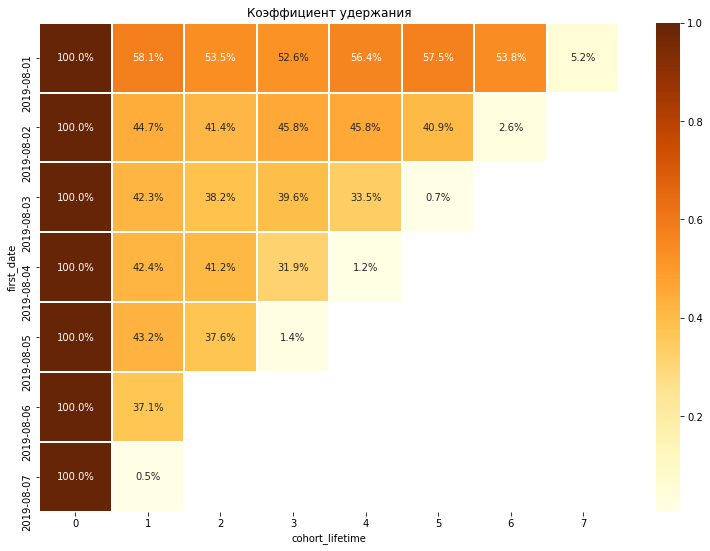

In [20]:
retention = new_table.fillna(0).copy()
# Найдём lifetime когорты



retention['cohort_lifetime'] = retention['date_time']- retention['first_datetime']
retention['cohort_lifetime'] = retention['cohort_lifetime'] / np.timedelta64(1,'D')
retention['cohort_lifetime'] = retention['cohort_lifetime'].round().astype('int')

# сгруппируем по 1 дню и lifetime и посчитаем уникальное количество пользователей 
cohorts = retention.groupby(['first_date','cohort_lifetime']).agg({'id':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_date','id']]
initial_users_count = initial_users_count.rename(columns={'id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_date')
cohorts['retention'] = cohorts['id']/cohorts['cohort_users']

#сформируем сводную таблицу по когортам
retention_pivot = cohorts.pivot_table(index='first_date',columns='cohort_lifetime',values='retention',aggfunc='sum')
#retention_pivot.index = retention_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(13, 9))

#построим тепловую карту
plt.title('Коэффициент удержания')
sns.heatmap(retention_pivot, cmap='YlOrBr',annot=True, fmt='.1%', linewidths=1, linecolor='white')
plt.show()

Самый большой коэффициент удержания у первой когорты пользователи которые зашли или совершили первые действия в приложении 1 августа больше - их коэффицент больше 50%. У остальных пользователей коэффициент удержания снижается, и составляет в среднем 40%

### Есть ли разница в конверсию в покупку у пользователей посещавших туториал и пропустивших обучение.
### Paying Conversion<a id="step13"></a>

Разобьем пользователей на 2 группы, и посмотрим, влияет ли использование Tutorial на оплату. У нас есть предположение, что пользователи которые заходили в этот раздел чаще становятся покупателями.

In [21]:
dont_help = table.query('HELP ==0')
helper = table.query('HELP > 0')


print('Конверсия пользователей не проходивших обучение - {:.2%}'.format(len(dont_help[dont_help['4_PAYMENT'] > 0]) / len(dont_help)))

print('Конверсия пользователей прошедших обучение - {:.2%}'.format(len(helper[helper['4_PAYMENT'] > 0]) / len(helper)))

Конверсия пользователей не проходивших обучение - 45.40%
Конверсия пользователей прошедших обучение - 54.73%


Невероятно как меняется процент конверсии в покупку пользователей которые зашли в раздел помощь относительно остальных пользователь. Мы видим что что те, которые разобрались лучше в приложение и лучше конвертируется в покупателей порядка 9% плюсом.

## Воронка событий <a id="step2"></a>


1. [Cобытия есть в логах](#step21)  
2. [Cколько пользователей совершали каждое из этих событий](#step22) 
3. [Доли пользователей по воронке](#step23) 
4. [Количество всех действий по дням](#step24)
4. [Выводы](#step25) 

### Посмотрим, какие события есть в логах, как часто они встречаются. Как распределяются пользователи и сколько доходят до оплаты?<a id="step21"></a>

In [22]:
new_table['eventname'].value_counts().sort_values(ascending=False)

MainScreenAppear           112712
OffersScreenAppear          40189
CartScreenAppear            27095
PaymentScreenSuccessful     20242
Tutorial                      974
Name: eventname, dtype: int64

Все события укладываются в хорошую воронку -  cначала это "Открыть главный экран" потом "открыть экран c предложением", "открыть экран оплаты" и 'успешная оплата".

Кроме события "Помощь" который может пользователи открыть как в начале использования приложения, так и например после того как мы уже совершил оплату и что то хочет уточнить. Мы не будем использовать в воронке "Помощь" но проверим позже насколько использование туториала повышает конверсию в продажу.

### Посмотрим, сколько пользователей совершали каждое из этих событий <a id="step22"></a>

Рассмотрим количество уникальных пользователей на каждой стадии воронки продаж.

In [23]:
voronka = new_table.groupby('eventname').agg(unic_id = ('id','nunique')).reset_index().\
                sort_values(by = 'unic_id', ascending=False).loc[:3:]

In [41]:
voronka1 = new_table.groupby('eventname').agg(unic_id = ('id','nunique')).reset_index().\
                sort_values(by = 'unic_id', ascending=False).loc[:3:]
voronka['new'] = 'cool'
voronka1['new'] = 'woow'
df = pd.concat([voronka, voronka1], axis=0)
df

,eventname,unic_id,new
1,MainScreenAppear,7311,cool
2,OffersScreenAppear,4482,cool
0,CartScreenAppear,3623,cool
3,PaymentScreenSuccessful,3428,cool
1,MainScreenAppear,7311,woow
2,OffersScreenAppear,4482,woow
0,CartScreenAppear,3623,woow
3,PaymentScreenSuccessful,3428,woow


In [45]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y =df["eventname"],
    x = df["unic_id"],textposition = 'inside',
    textinfo = 'value+percent initial'))

fig.update_layout(title_text='Сколько пользователей было на каждом шаге')
fig.show()

Почти 47% от пользователей, посетивших главную страницу в итоге купили - это отличный показатель, что пользователи , которые посещают приложения - являются качественными.

### Доли пользователей по воронке <a id="step23"></a>

In [25]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y =voronka["eventname"],
    x = voronka["unic_id"],textposition = 'inside',
    textinfo = 'value+percent previous'))

fig.update_layout(title_text='Какая доля пользователей проходит на следующий шаг воронки ')
fig.show()


Мы видим что самое большое падение это 38,5% происходит на этапе перехода пользователя от главного экрана на экран предложения товара. На этот этап попадает только 4517 пользователей. Уже остальные падение пользователей не такие критичные, например на этап - успешной оплаты переходит 94,7% от всех пользователей которые попали на экран оплаты

### Количество всех действий по дням.  <a id="step24"></a>

Первый экран, предложение, оплата, покупка

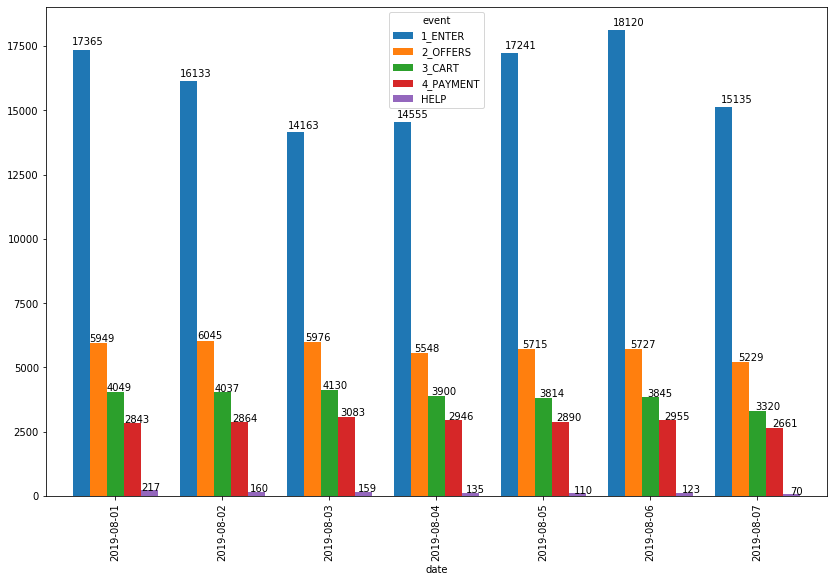

In [26]:
ax = new_table.pivot_table(index = 'date', columns = 'event', values = 'id', aggfunc = 'count').\
        plot(kind = 'bar',figsize=(14, 9),width = 0.8)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() * 1.01, p.get_height() * 1.01))

 Мы видим что идет рост посещений главной странице но нет такого же роста оплаты в эти дни

### Выводы.  <a id="step25"></a>

Большая часть пользователь отсеивается после первого шага на переходе странице заказа, скорее всего надо упростить приложение и "провезти пользователя за руку" чтобы он смог конвертироваться в покупателя.

## Результаты эксперимента  <a id="step3"></a>

Проверим сколько пользователей в каждой экспериментальной группе?

In [27]:
count_p = new_table.groupby('exper').agg( count_id = ('id','nunique'))
count_p = count_p.T
count_p

exper,246,247,248
count_id,2441,2477,2505


Количество пользователей приверно одинаково, для групп А\А - это 246 и 247 номера. И немного больше - 2505 для группы В - в тестировании.

Посмотрим распределение уникальных пользователей по группам и событиям.

In [28]:
stat_table = new_table.pivot_table(index = 'event', columns = 'exper', values = 'id', aggfunc = 'nunique')
stat_table = count_p.append(stat_table)
stat_table

exper,246,247,248
count_id,2441,2477,2505
1_ENTER,2408,2441,2462
2_OFFERS,1499,1484,1499
3_CART,1223,1202,1198
4_PAYMENT,1157,1122,1149
HELP,266,277,275


### Проверим корректность всех механизмов и расчётов

#### Сформируем нулевую гипотезу - группы которые использовались для АА тестирования различны. 

Будем считать как меняется отношение количества уникальных пользователей, дошедших до определенного этапа воронки в общему числу пользователей в данной выборке.

Сравниваем конверсии count_id->1_ENTER, count_id->2_OFFERS, count_id->3_CART, count_id->4_PAYMENT

In [29]:
stat(stat_table, 246, 247,  .05)

p-значение:  0.7622784084629441
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 1_ENTER
p-значение:  0.28226466771927083
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 2_OFFERS
p-значение:  0.2690373814861071
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 3_CART
p-значение:  0.13942398795414324
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 4_PAYMENT


Получается что наши группы  246 и 247 одинаковы и пригодны для А В тестирования. И даже конверсия у них идетнична.

### Рассчитаем разницу при тестировании с группой в измененными шрифтами.

Выдвинем нулевую гипотезу - предположим, что шрифт не поменял конверсию в группе. 

In [30]:
alpha = .05
bonferroni_alpha = alpha / 2
stat(stat_table, 246, 248,  bonferroni_alpha)

p-значение:  0.2972267861067519
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 1_ENTER
p-значение:  0.2588795466285063
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 2_OFFERS
p-значение:  0.10908182775920183
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 3_CART
p-значение:  0.28075306984452575
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 4_PAYMENT


In [31]:
stat(stat_table, 247, 248, bonferroni_alpha)

p-значение:  0.4571559092107558
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 1_ENTER
p-значение:  0.9593079003538394
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 2_OFFERS
p-значение:  0.6199771358705486
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 3_CART
p-значение:  0.6854897697153137
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 4_PAYMENT


Получается, что изменненый шрифт не повлиял на конверсию в покупку группы В относительно групп АА.

Изменим уровень статистической значимости на 0.1

In [32]:
alpha = .01
bonferroni_alpha = alpha / 2
stat(stat_table, 246, 248,  alpha)

p-значение:  0.2972267861067519
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 1_ENTER
p-значение:  0.2588795466285063
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 2_OFFERS
p-значение:  0.10908182775920183
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 3_CART
p-значение:  0.28075306984452575
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 4_PAYMENT


In [33]:
alpha = .01
bonferroni_alpha = alpha / 2
stat(stat_table, 247, 248,  alpha)

p-значение:  0.4571559092107558
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 1_ENTER
p-значение:  0.9593079003538394
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 2_OFFERS
p-значение:  0.6199771358705486
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 3_CART
p-значение:  0.6854897697153137
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 4_PAYMENT


Сделаем группу АА - 245 - и сравним ее с В

In [34]:
stat_table[245] = stat_table[246]+stat_table[247]
stat_table

exper,246,247,248,245
count_id,2441,2477,2505,4918
1_ENTER,2408,2441,2462,4849
2_OFFERS,1499,1484,1499,2983
3_CART,1223,1202,1198,2425
4_PAYMENT,1157,1122,1149,2279
HELP,266,277,275,543


Проверим ту же гипотезу - шрифт не поменял конверсию в заказах у основной грууппы клиентов.

In [35]:
alpha = .05
bonferroni_alpha = alpha / 2
stat(stat_table, 245, 248,  alpha)

p-значение:  0.29469821858725265
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 1_ENTER
p-значение:  0.4975516515922547
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 2_OFFERS
p-значение:  0.22638435625125752
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 3_CART
p-значение:  0.6998921767715478
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 4_PAYMENT


Поменяем уровень alpha  на 0.1  и проверим измениться ли что нибудь.

In [36]:
stat(stat_table, 245, 248,  .01)

p-значение:  0.29469821858725265
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 1_ENTER
p-значение:  0.4975516515922547
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 2_OFFERS
p-значение:  0.22638435625125752
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 3_CART
p-значение:  0.6998921767715478
Не oтвергаем нулевую гипотезу: нет оснований считать доли разными,проверили количество пользователей и уровень - 4_PAYMENT


Даже при этом критическом уровене статистической значимости группы оказались идентичными.

## Выводы  <a id="step4"></a>

### Общие данные

Мы посмотрели на наших пользователей продуктового предложения и можем сказать следующее:

У нас полностью есть 7 дней которых пользователь совершали и какие-то определенные действия в нашем приложении, всего таких действий у нас 5 видов:

>* Вход в приложение   
>* Страница заказа
>* Страница оплаты
>* Успешная покупка
>* Помощь
<br><br>


При этом мы понимаем, что пользователь мог попасть на страницу оплаты - минуя первые 2 -3 экрана , из пуш уведомления или из забытой корзины.

В среднем за 7 дней использования количество событий на одного пользователя равно -  __20__

Мы ___почистили выборку___ и удалили из нее излишне активных пользователей  - более 200 логов, и тех кто активно платил. Это те у кого было более 40 платежей за 7 дней

Самый большой ___коэффицент удержания___ у первой когорты пользователи которые зашли или совершили первые действия в приложении 1 августа больше - их коэффициент больше 50%. У остальных пользователей коэффициент удержания снижается, и составляет в среднем 40%.

___Конверсия в покупку достаточно велика - почти 47%___ от пользователей, посетивших главную страницу в итоге купили - это отличный показатель, что пользователи , которые посещают приложения - являются качественными.

### Идеи для улучшения продукта:

Так же мы проанализировали ___поведение пользователей в зависимости от помещения / не посещения раздела помощи___. Мы видим, что те, которые разобрались лучше в приложение и лучше конвертируется в покупателей порядка __9% плюсом. Надо мотивировать пользователей обращаться в  раздел помощь - это принесет нам больше денег__

Самый ___большой отток пользователей___ мы видим на этапе переходе с главного экрана в этапа заказа. на этом этапе пропадают 39 процентов потенциальных покупателей. __Мы можем изменить главную страницу - и добавить акций, для покупателей либо купонов на быструю покупку - чтобы мотивировать переходить дальше.__

Мы видим, что идет рост посещений приложения 05- 06 числа - но ___нет роста оплаты___ вслед за посещением, __надо разобраться почему пошли некачественные лиды.___

### Эксперимент со шрифтами

Результат эксперимента показал, что шрифты не поменяли отношения пользователя к покупке и не увеличили конверсию в продажу. ___Надо продолжать эксперименты с более значимыми для пользователя элементами.___